# Construcción de curva cero: CETES y M BONOS #
### 23 deagosto de 2021 ###

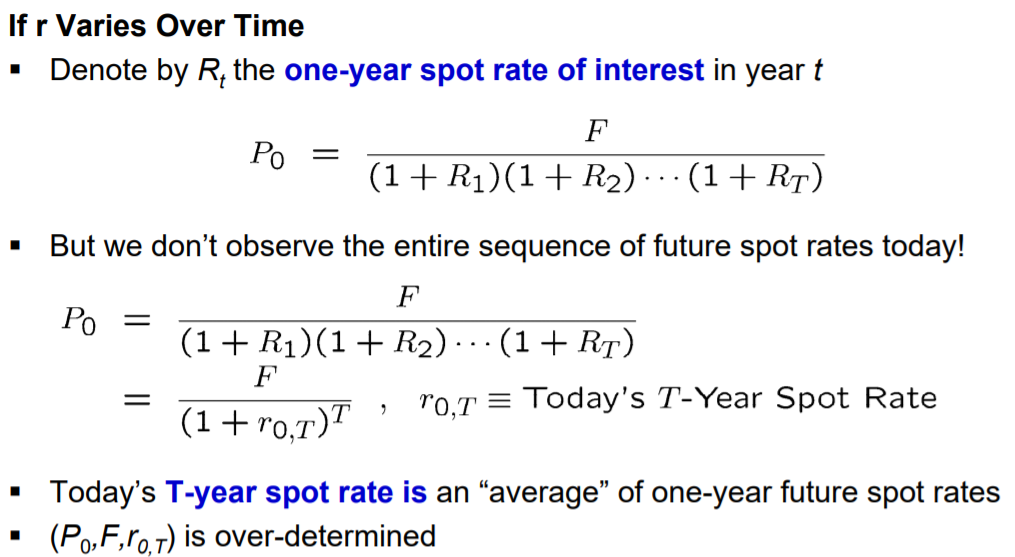

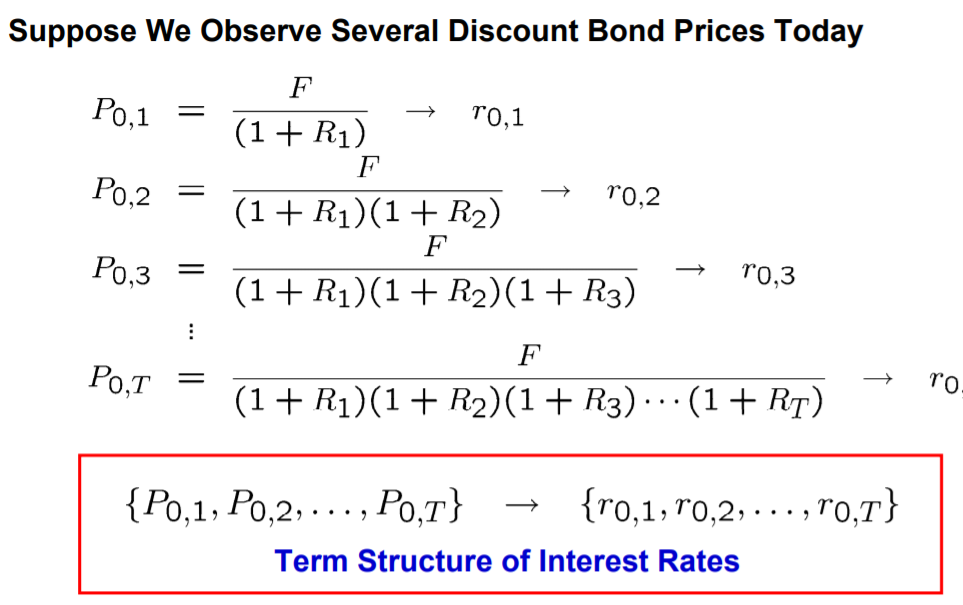

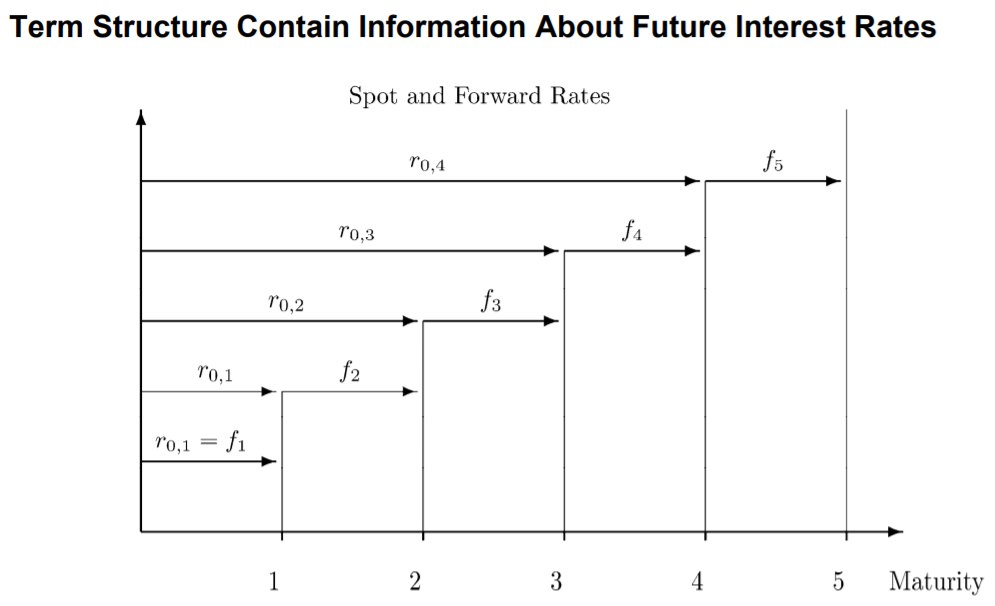

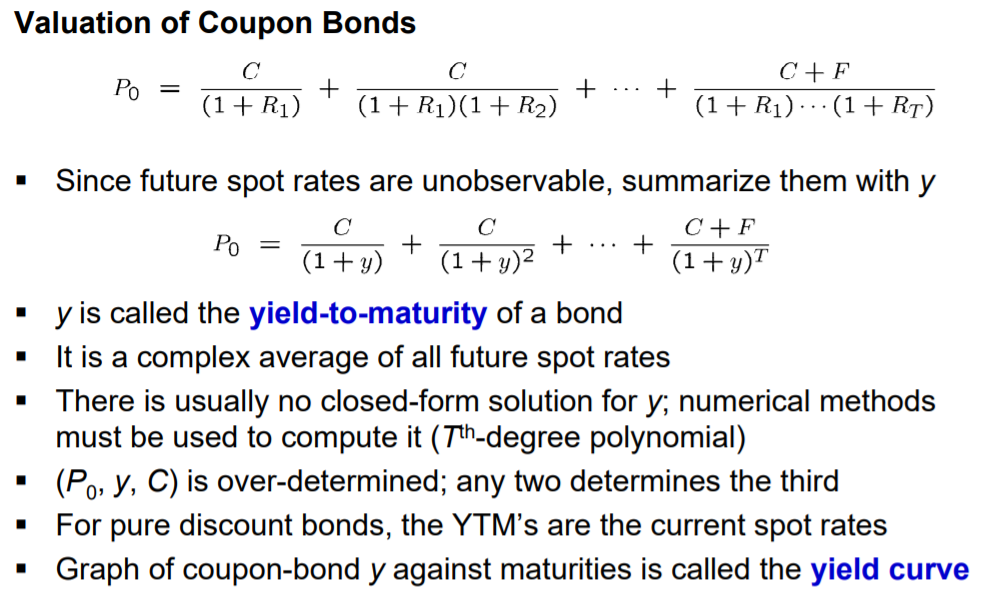

*Diapositivas tomadas de: https://ocw.mit.edu/courses/sloan-school-of-management/15-401-finance-theory-i-fall-2008/*

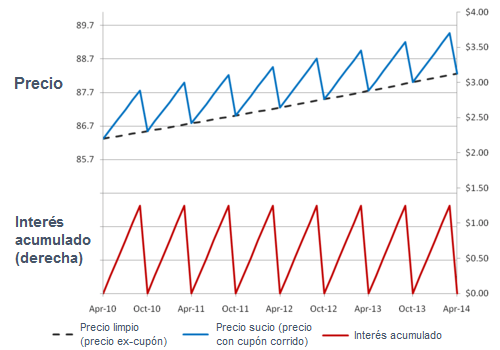

### Librerías, clases y funciones que usaremos ###

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [2]:
# Una de las opciones, se pueden utilizar arrays, dataframes, listas, tuplas, diccionarios
class Curve:
    def __init__(self, plazos, factor_desc):
        self._plazos = np.array(plazos)
        self._fd = np.array(factor_desc)

In [3]:
def calcular_precio_sucio(dias_venc, valor_nominal, dias_cupon, tasa_cupon, ytm):
    n = (np.ceil(dias_venc / dias_cupon))
    dtcv = n * dias_cupon - dias_venc #dias transcurridos del cupon vigente
    c = valor_nominal * tasa_cupon * dias_cupon / 360
    anualidad = (1 - 1 / (1 + ytm * dias_cupon / 360) ** n) / (ytm * dias_cupon / 360)
    precios = (c * anualidad + valor_nominal / (1 + ytm * dias_cupon / 360) ** n) * (1 + ytm * dias_cupon / 360) ** (dtcv / dias_cupon)
    return precios

def interpolar(plazo, curva_fd, curva_plazos, tipo="lineal tasas"):
    if tipo == "lineal tasas":
        curva_tasas = []
        for i in range(len(curva_plazos)):
            tasa_cero_anual = (-360*(curva_fd[i]-1))/(curva_plazos[i]*curva_fd[i])
            curva_tasas.append(tasa_cero_anual)
        interpolador_scipy = interp1d(np.array(curva_plazos), np.array(curva_tasas))
        nueva_tasa = float(interpolador_scipy(plazo))
        nuevo_fd = 1 / (1 + nueva_tasa * plazo/360)
        return nuevo_fd
    else:
        return

def descontar_flujos(x, precio_sucio, cupon, cal_flujos, curva_fd, curva_plazos):
    print('Guess: ', x)
    curva_fd[-1] = x[-1]
    valor_nominal = 100
    npv = 0
    for i in range(len(cal_flujos)):
        if cal_flujos[i] in curva_plazos:
            index = curva_plazos.index(cal_flujos[i])
            npv += valor_nominal * cupon * curva_fd[index]
            if i == len(cal_flujos)-1:
                npv += valor_nominal * curva_fd[index]
        else:
            fd = interpolar(cal_flujos[i], curva_fd, curva_plazos)
            npv += valor_nominal * cupon * fd
    return npv - precio_sucio
        

def encontrar_tasa_cero(dias_venc, precio_sucio, dias_cupon, tasa_cupon, curva_fd, curva_plazos):
    n = int(np.ceil(dias_venc / dias_cupon))
    cupon = tasa_cupon * dias_cupon / 360
    cal_flujos = [dias_venc-i*dias_cupon for i in range(n)]
    cal_flujos.reverse()
    nuevo_fd = fsolve(descontar_flujos, curva_fd[-1],
                      args=(precio_sucio, cupon, cal_flujos, curva_fd, curva_plazos))
    return nuevo_fd[0]
    
        

### Bootstrapping ###
Metodología que se utiliza para obtener tasas cero a partir de instrumentos cuponados

In [4]:
fecha_pricing = '20210818'
fecha_pricing = pd.to_datetime(fecha_pricing, format='%Y%m%d')
# Cargar los datos de mercado para la construcción de la curva
datos_mercado = pd.read_csv("datos_de_mercado.csv")
datos_mercado['Vencimiento'] = pd.to_datetime(datos_mercado['Vencimiento'], format='%d/%m/%Y', dayfirst=True)
datos_mercado['Plazo a Venc'] = datos_mercado['Vencimiento'] - fecha_pricing
datos_mercado['Plazo a Venc'] = datos_mercado['Plazo a Venc'].astype('timedelta64[D]').astype(int)
datos_mercado

,Nombre,Cupon,Vencimiento,YTM,Plazo a Venc
0,TFB,0.0,2021-08-19,4.24,1
1,CETES,0.0,2021-09-15,4.00,28
2,CETES,0.0,2022-02-16,4.50,182
3,MBONO,5.0,2023-07-09,6.00,690
4,MBONO,8.0,2031-08-16,7.00,3650


In [5]:
# Construccion de la curva
curva_fd = []
curva_plazos = []

for i in range(len(datos_mercado)):
    if datos_mercado['Cupon'].iloc[i] == 0:
        # Podemos obtener el fd y la tasa cero directamente
        fd = 1 / (1 + datos_mercado['YTM'].iloc[i]/100 * datos_mercado['Plazo a Venc'].iloc[i]/360)
        curva_fd.append(fd)
        curva_plazos.append(datos_mercado['Plazo a Venc'].iloc[i])
        print('Factor Desc: ', (datos_mercado['Plazo a Venc'].iloc[i], fd))
    else:
        #Estimacion inicial
        curva_plazos.append(datos_mercado['Plazo a Venc'].iloc[i])
        fd = 1 / (1 + datos_mercado['YTM'].iloc[i]/100 * datos_mercado['Plazo a Venc'].iloc[i]/360)
        curva_fd.append(fd)
        precio_sucio = calcular_precio_sucio(datos_mercado['Plazo a Venc'].iloc[i],
                                             100,
                                             182,
                                             datos_mercado['Cupon'].iloc[i]/100,
                                             datos_mercado['YTM'].iloc[i]/100)
        fd = encontrar_tasa_cero(datos_mercado['Plazo a Venc'].iloc[i],
                                 precio_sucio,
                                 182,
                                 datos_mercado['Cupon'].iloc[i]/100,
                                 curva_fd,
                                 curva_plazos)
        curva_fd[-1] = fd
        print('Factor Desc: ', (datos_mercado['Plazo a Venc'].iloc[i],fd))
        print('---------------------------')
        
        
print('Listo!')

Factor Desc:  (1, 0.9998822360921935)
Factor Desc:  (28, 0.9968985378821444)
Factor Desc:  (182, 0.9777560498655585)
Guess:  [0.89686099]
Guess:  [0.89686099]
Guess:  [0.89686099]
Guess:  [0.896861]
Guess:  [0.89237162]
Guess:  [0.89237184]
Guess:  [0.89237184]
Factor Desc:  (690, 0.8923718374289938)
---------------------------
Guess:  [0.58489033]
Guess:  [0.58489033]
Guess:  [0.58489033]
Guess:  [0.58489034]
Guess:  [0.48990249]
Guess:  [0.49141122]
Guess:  [0.49138564]
Guess:  [0.49138563]
Guess:  [0.49138563]
Factor Desc:  (3650, 0.4913856340702015)
---------------------------
Listo!


### Resultados ###

In [9]:
print('Curva cero')
print('-----------')
print('Plazo\tFactor Desc')
for i, j in zip(curva_fd, curva_plazos):
    print(j,'\t', i)

Curva cero
-----------
Plazo	Factor Desc
1 	 0.9998822360921935
28 	 0.9968985378821444
182 	 0.9777560498655585
690 	 0.8923718374289938
3650 	 0.4913856340702015


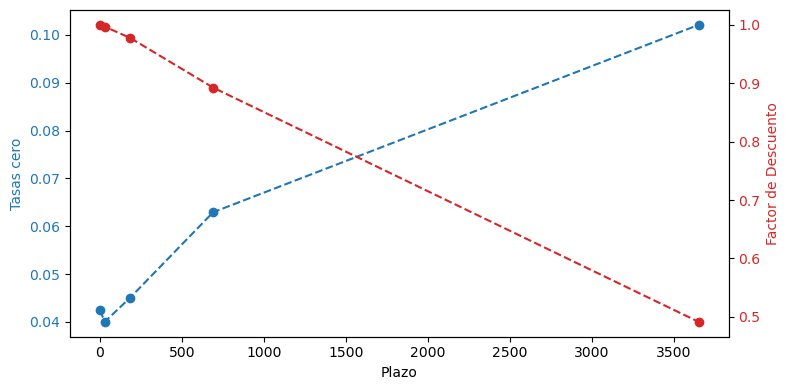

In [7]:
curva_tasas = []
for i in range(len(curva_plazos)):
    tasa_cero_anual = (-360*(curva_fd[i]-1))/(curva_plazos[i]*curva_fd[i])
    curva_tasas.append(tasa_cero_anual)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Plazo')
ax1.set_ylabel('Tasas cero', color=color)
ax1.plot(curva_plazos, curva_tasas, 'o--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Factor de Descuento', color=color)
ax2.plot(curva_plazos, curva_fd, 'o--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.set_size_inches(8, 4)
fig.tight_layout()
plt.show()

### Ejercicio ###
Crear una clase de Curva, Bono, Interpolacion

In [ ]:
# Podríamos crear una clase en la que guardar los datos de nuestra curva
class Curva:
    def __init__(self, plazos->list, factores_dec->list):
        self.plazos = plazos
        self.factores_desc = factores_dec
    
    def get_factor_desc(self, plazo):
        pass
    
    def añadir_nodo(self, plazo_nuevo, fd_nuevo):
        self.plazos.append(plazo_nuevo)
        self.factores_desc.append(fd_nuevo)

class Bono:
    pass

class Interpolacion:
    pass